# Urban Heat Island (UHI) Benchmark Notebook

## Challenge Overview

<p align="justify">The objective of the EY Open Science AI & Data Challenge 2025 is to build a machine learning model to predict urban heat island (UHI) hotspots in a city (here NYC).

We were given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. We used this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

<b>Roadmap: </b><p align="justify"> <p>

In this notebook, we will demonstrate how we constructed a basic Random Forest model to predict the Urban Heat Island (UHI) index using features from:

1. Predictor variables from Sentinel-2-Level-2A satellite data
2. Predictor variables from Landsat 8 Collection 2 Level-2 satellite data
3. Predictor variables Landsat Collection 2 Level-2 satellite data
4. Building footprint dataset
5. Elevation dataset


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
!pip install planetary-computer odc.stac pystac_client stackstac rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.5 MB/s eta 0:00:00


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset (New York region). The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location.

<h10 style="color:rgb(255, 255, 0)"><strong>Note: We were strictly prohibited from using Longitude and Latitude values as features in building the machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations.</strong></h10>

<h10 style="color:rgb(255, 255, 0)"><strong>Incorporating latitude and longitude data in their raw forms or through any form of manipulation—including multiplication, embedding, or conversion to polar coordinates—as predictive features in our model was strictly prohibited, as it can compromise the adaptability of our model across diverse scenarios. This prohibition extends to calculating the distance from a reference point and using it as a feature, which is essentially a transformation of the original geographical coordinates into a new feature form.</strong></h10>

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("/content/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## 1. Predictor variables from Sentinel-2-Level-2A satellite data

These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B02, B03, B04, B06, B08 and B11 for this specific date are representative of the UHI index behavior at any location.


<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. We show in the provided Sentinel-2 sample notebook how to create a sample GeoTIFF for this model. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. We are choosing the following bands as predictor variables for this experiment.</p>

B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.

B02 - Reflectance values from the Blue band (490nm), useful for analyzing water bodies, atmospheric corrections, and distinguishing features in coastal and aquatic environments.

B03 - Reflectance values from the Green band (560nm), used for vegetation monitoring, distinguishing land cover types, and assessing chlorophyll content.

B04 - Reflectance values from the Red band (665nm), key for vegetation health analysis, detecting plant stress, and land cover classification.

B06 - Reflectance values from the Red Edge 2 band (740nm), useful for detecting vegetation stress, estimating chlorophyll content, and improving agricultural monitoring.

B08 - Reflectance values from the Near Infrared (NIR) band (842nm), essential for assessing vegetation vigor, biomass estimation, and water content analysis.

B11 - Reflectance values from the Shortwave Infrared 1 (SWIR-1) band (1610nm), used for analyzing soil moisture, vegetation water content, and detecting burned areas or drought conditions.

NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.

EVI - (Enhanced Vegetation Index) - Similar to NDVI but incorporates B02 (Blue) along with B04 (Red) and B08 (NIR) to correct for atmospheric influences and soil background effects, making it more accurate in high-biomass areas.

SAVI - (Soil Adjusted Vegetation Index) - A vegetation index that modifies NDVI by incorporating a soil brightness correction factor, making it useful for areas with sparse vegetation or exposed soil.

MNDWI - (Modified Normalized Difference Water Index) - Derived from B03 (Green) and B11, MNDWI is designed to detect and map water bodies more effectively by minimizing soil and vegetation interference.

NDBI - (Normalized Difference Built-Up Index) - Derived from B11 and B08 , NDBI is used for identifying and mapping built-up urban areas by detecting surfaces like concrete and asphalt.

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">We might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, we can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

<h4 style="color:rgb(255, 255, 0)"><strong>Analyze the Sentinel-2 Data</strong></h4>

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). You can review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Methods of Extracting Band Values from Sentinel-2 Data</strong></h4>

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

You can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image.

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, we might explore other options to improve data quality. For example, we could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>




### Extracting Band Values from the GeoTIFF Image


In [4]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_sentinel(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B11_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B02_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B02_values.append(B02_value)

        B03_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B03_values.append(B03_value)

        B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)

        B06_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B06_values.append(B06_value)

        B08_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B08_values.append(B08_value)

        B11_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
        B11_values.append(B11_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B11'] = B11_values

    return df


In [5]:
final_data_sentinel = map_satellite_data_sentinel('/content/S2_sample-2.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [01:50<00:00, 101.89it/s]


In [6]:
final_data_sentinel.head()

,B01,B02,B03,B04,B06,B08,B11
0,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0
1,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0
2,846.0,583.0,818.0,709.0,1668.0,2190.0,1465.0
3,846.0,581.0,733.0,657.0,1668.0,2182.0,1465.0
4,846.0,655.0,744.0,745.0,1728.0,2112.0,1544.0


In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
final_data_sentinel['NDVI'] = (final_data_sentinel['B08'] - final_data_sentinel['B04']) / (final_data_sentinel['B08'] + final_data_sentinel['B04'])
final_data_sentinel['NDVI'] = final_data_sentinel['NDVI'].replace([np.inf, -np.inf], np.nan)

eps =  1e-8
# this is used to handle division by zero by adding a small term to the denominator in the calculation of the following bands
# EVI Calculation
final_data_sentinel['EVI'] = 2.5*(final_data_sentinel['B08']-final_data_sentinel['B04'])/(final_data_sentinel['B08']+6*final_data_sentinel['B04']-7.5*final_data_sentinel['B02']+1+eps)

# SAVI Calculation
final_data_sentinel['SAVI'] = ((final_data_sentinel['B08']-final_data_sentinel['B04'])/(final_data_sentinel['B08']+final_data_sentinel['B04']+0.5+eps))*(1+0.5)

# MNDWI Calculation
final_data_sentinel['MNDWI'] = (final_data_sentinel['B03']-final_data_sentinel['B11'])/(final_data_sentinel['B03']+final_data_sentinel['B11']+eps)

# NDBI Calculation
final_data_sentinel['NDBI'] = (final_data_sentinel['B11']-final_data_sentinel['B08'])/(final_data_sentinel['B11']+final_data_sentinel['B08']+eps)

##2. Predictor variables from Landsat 8 Collection 2 Level-2 data

As same as for the Sentinel-2 data, we created a GeoTIFF image from the Landsat-8 satellite for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted:
- B10: Measures surface temperature.
- CDIST (Central Wavelength Distance): Provides pixel-wise central wavelength distance for radiometric corrections.
- ATRAN (Atmospheric Transmittance): Indicates how much atmospheric interference affects surface reflectance.
- DRAD (Downwelling Radiance): Measures incoming radiation from the atmosphere, useful for surface energy balance studies.
- QA (Quality Assessment Band): Encodes pixel reliability, identifying issues like clouds or sensor errors.
- EMIS (Emissivity): Represents surface emissivity, crucial for accurate land surface temperature estimation.

In [8]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_landsat(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B10_values = []
    CDIST_values = []
    ATRAN_values = []
    DRAD_values = []
    QA_values = []
    EMIS_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        B10_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B10_values.append(B10_value)

        CDIST_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        CDIST_values.append(CDIST_value)

        ATRAN_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        ATRAN_values.append(ATRAN_value)

        DRAD_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        DRAD_values.append(DRAD_value)

        QA_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        QA_values.append(QA_value)

        EMIS_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        EMIS_values.append(EMIS_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B10'] = B10_values
    df['CDIST'] = CDIST_values
    df['ATRAN'] = ATRAN_values
    df['DRAD'] = DRAD_values
    df['QA'] = QA_values
    df['EMIS'] = EMIS_values

    return df

In [9]:
# Mapping satellite data with training data.
final_data = map_satellite_data_landsat('/content/Landsat_LST.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [01:32<00:00, 121.23it/s]


In [10]:
final_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS
0,49905.0,5497.0,110.0,1659.0,370.0,9667.0
1,49905.0,5497.0,110.0,1659.0,370.0,9667.0
2,49488.0,5497.0,111.0,1659.0,377.0,9729.0
3,49488.0,5497.0,111.0,1659.0,377.0,9729.0
4,49441.0,5497.0,109.0,1659.0,378.0,9729.0


##3. Predictor variables from the Landsat Collection 2 Level-2 satellite data

As for the Sentinel-2 data, we created a GeoTIFF image from the Landsat-8 satellite for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted:
- red: used for vegetation monitoring and land cover classification.
- green: helps assess vegetation health and water clarity.
- blue: useful for analyzing water bodies and detecting atmospheric haze.
- nir08: essential for vegetation health and biomass studies.
- lwir11: measures land surface temperature for climate and UHI analysis.
- cdist (Central Wavelength Distance): provides pixel-wise central wavelength distance for radiometric corrections.
- atran (Atmospheric Transmittance): indicates how much atmospheric interference affects surface reflectance.
- qa (Quality Assessment Band): identifies pixel reliability issues like clouds and sensor errors.
- emis (Emissivity): represents surface emissivity, crucial for accurate land surface temperature estimation.

In [11]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_landsatog(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    red = []
    green = []
    blue = []
    nir08 = []
    lwir11 = []
    cdist = []
    atran = []
    qa = []
    emis = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        red_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        red.append(red_value)

        green_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        green.append(green_value)

        blue_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        blue.append(blue_value)

        nir08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        nir08.append(nir08_value)

        lwir11_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        lwir11.append(lwir11_value)

        cdist_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        cdist.append(cdist_value)

        atran_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
        atran.append(atran_value)

        qa_value = data.sel(x=lon, y=lat, band=8, method="nearest").values
        qa.append(qa_value)

        emis_value = data.sel(x=lon, y=lat, band=9, method="nearest").values
        emis.append(emis_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['red'] = red
    df['green'] = green
    df['blue'] = blue
    df['nir08'] = nir08
    df['lwir11'] = lwir11
    df['cdist'] = cdist
    df['atran'] = atran
    df['qa'] = qa
    df['emis'] = emis

    return df


In [12]:
# Mapping satellite data with training data.
final_data_landsatog = map_satellite_data_landsatog('/content/Landsat_LST_og-2.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [02:19<00:00, 80.34it/s]


In [13]:
final_data_landsatog.head()

,red,green,blue,nir08,lwir11,cdist,atran,qa,emis
0,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0
1,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0
2,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0
3,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0
4,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,8507.0,323.0,9728.0


##4. Elevation Dataset
https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/nasadem/nasadem-example.ipynb

In [14]:
!pip install datashader
!pip install datashader[spatial]
!pip install xarray-spatial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00


In [15]:
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from xrspatial import hillshade

import pystac_client
import planetary_computer
import rioxarray

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [16]:
# Interesting places for looking at SRTM data
new_york_city = [-74.01, 40.75]

areas_of_interest = {"type": "Point", "coordinates": new_york_city}

In [17]:
search = catalog.search(collections=["nasadem"], intersects=areas_of_interest)

items = search.item_collection()

print(f"Returned {len(items)} Items")

Returned 1 Items


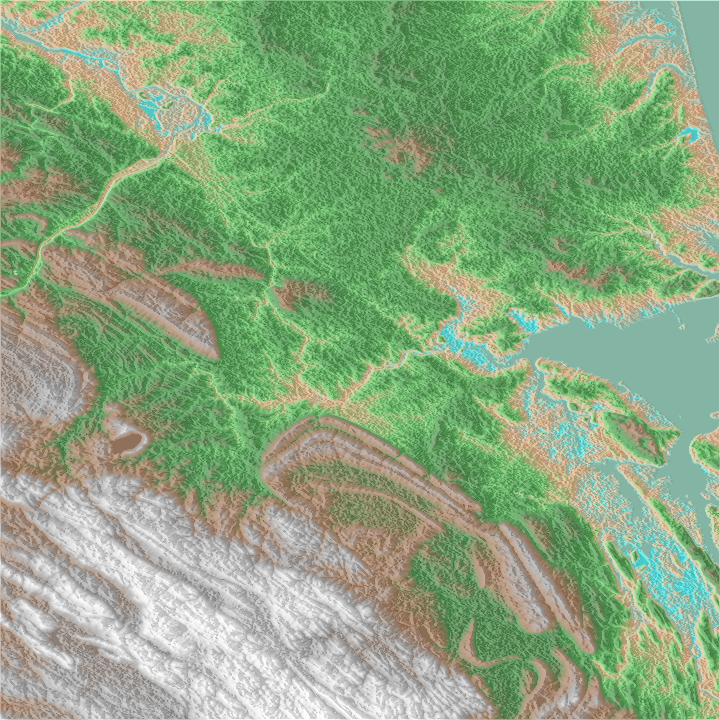

In [18]:
item = items[0]
item.assets
da = (
    rioxarray.open_rasterio(item.assets["elevation"].href)
    .squeeze()
    .drop("band")[:-1, :-1]
    .coarsen({"y": 5, "x": 5})
    .mean()
)
# Render the hillshade with a coloramp of the values applied on top
shaded = hillshade(da, azimuth=100, angle_altitude=50)
stack(shade(shaded, cmap=["white", "gray"]), shade(da, cmap=Elevation, alpha=128))

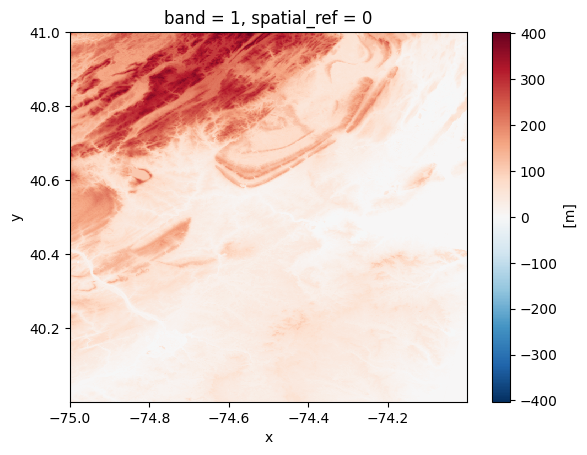

In [19]:
# prompt: can we explore this as a geotiff file with elevation as a band
import rioxarray
import matplotlib.pyplot as plt

# Assuming 'da' is your xarray DataArray from the previous code
# and represents the elevation data

# Convert the DataArray to a GeoTIFF
da.rio.to_raster("elevation.tiff")

# Open the GeoTIFF using rioxarray
elevation_geotiff = rioxarray.open_rasterio("elevation.tiff")

# Display the GeoTIFF (optional)
elevation_geotiff.plot()
plt.show()

In [20]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_elevation(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    elevation = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        elevation_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        elevation.append(elevation_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['elevation'] = elevation

    return df


In [21]:
final_data_elevation = map_satellite_data_elevation('/content/elevation.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:18<00:00, 602.90it/s]


##5. Building Footprint Dataset

In [22]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.transform import from_origin
from shapely.geometry import box

# Load KML file directly
buildings = gpd.read_file("/content/Building_Footprint.kml")

# Ensure geometries are valid
buildings = buildings.explode(ignore_index=True)  # Convert MultiPolygon to individual Polygons

# Define grid parameters
xmin, ymin, xmax, ymax = buildings.total_bounds
pixel_size = 0.001  # Set grid resolution (adjust as needed)
cols = int((xmax - xmin) / pixel_size)
rows = int((ymax - ymin) / pixel_size)

# Create an empty density grid (to store fractions)
density_array = np.zeros((rows, cols), dtype=np.float32)

# Compute building density as fractions
for i in range(rows):
    for j in range(cols):
        # Define the current grid cell
        cell = box(
            xmin + j * pixel_size, ymin + i * pixel_size,
            xmin + (j + 1) * pixel_size, ymin + (i + 1) * pixel_size
        )

        # Calculate the total area of the grid cell
        cell_area = cell.area

        # Calculate the total building area within the grid cell
        building_area = 0

        # Get intersecting buildings as a GeoDataFrame
        intersecting_buildings = buildings[buildings.intersects(cell)]

        # Iterate through intersecting buildings to calculate total area
        for idx, building in intersecting_buildings.iterrows():
            building_area += building.geometry.area

        # Calculate the fraction of the grid cell covered by buildings
        density_array[i, j] = building_area / cell_area if cell_area > 0 else 0

# Save as GeoTIFF
transform = from_origin(xmin, ymax, pixel_size, pixel_size)
with rasterio.open(
    "BuildingDensityFraction.tiff", "w", driver="GTiff",
    height=rows, width=cols, count=1,
    dtype=rasterio.float32, crs=buildings.crs,
    transform=transform
) as dst:
    dst.write(density_array, 1)

print("GeoTIFF file 'BuildingDensityFraction.tiff' created successfully!")

GeoTIFF file 'BuildingDensityFraction.tiff' created successfully!


In [23]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_building_density(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    building_density = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        building_density_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        building_density.append(building_density_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['building_density'] = building_density

    return df


In [24]:
final_data_building_density = map_satellite_data_building_density('/content/BuildingDensityFraction.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:14<00:00, 777.80it/s]


In [25]:
final_data_building_density['building_density'].value_counts()

,count
building_density,
0.0,6524
1.8589406,52
1.0504245,32
0.105768,30
7.6196713,30
...,...
1.7178335,1
1.671095,1
0.371999,1


## Landcover Dataset
https://planetarycomputer.microsoft.com/dataset/esa-worldcover#Example-Notebook

We extracted predictor variables from landcover dataset but it turned out that they didn't have much influence on the UHI index so we didn't use it in the end

In [26]:
bbox_of_interest = [-74.01, 40.75, -73.86, 40.88]

In [27]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox_of_interest,
)

items = list(search.get_items())
items

[<Item id=ESA_WorldCover_10m_2021_v200_N39W075>,
 <Item id=ESA_WorldCover_10m_2020_v100_N39W075>]

In [28]:
import rioxarray
import rasterio

# Assuming 'items' from your provided code contains the relevant STAC item
item = items[0]  # Or select the specific item you need

# Open the land cover data using rioxarray
landcover_data = rioxarray.open_rasterio(item.assets["map"].href)

# Access the land cover data array
landcover_array = landcover_data.data[0]

# Get the GeoTIFF's spatial information
transform = landcover_data.rio.transform()
crs = landcover_data.rio.crs

# Define the output GeoTIFF file name
output_filename = "landcover.tiff"

# Write the land cover data to a GeoTIFF file using rasterio
with rasterio.open(
    output_filename,
    "w",
    driver="GTiff",
    height=landcover_array.shape[0],
    width=landcover_array.shape[1],
    count=1,
    dtype=landcover_array.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(landcover_array, 1)

print(f"Land cover GeoTIFF saved to {output_filename}")


Land cover GeoTIFF saved to landcover.tiff


In [29]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_landcover(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    landcover = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        landcover_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        landcover.append(landcover_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['landcover'] = landcover

    return df


In [30]:
final_data_landcover = map_satellite_data_landcover('/content/landcover.tiff', '/content/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:15<00:00, 704.97it/s]


In [31]:
final_data_landcover['landcover'].value_counts()

,count
landcover,
50,9614
10,1534
60,50
30,16
80,15


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.

In [32]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [33]:
uhi_data = combine_two_datasets(ground_df,final_data_landsatog)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,red,green,blue,nir08,lwir11,cdist,atran,qa,emis
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,8507.0,323.0,9728.0


In [34]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(uhi_data,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,red,green,blue,nir08,lwir11,cdist,atran,qa,emis,B10,CDIST,ATRAN,DRAD,QA,EMIS
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0,49905.0,5497.0,110.0,1659.0,370.0,9667.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,8507.0,313.0,9665.0,49905.0,5497.0,110.0,1659.0,370.0,9667.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0,49488.0,5497.0,111.0,1659.0,377.0,9729.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,8507.0,322.0,9728.0,49488.0,5497.0,111.0,1659.0,377.0,9729.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,8507.0,323.0,9728.0,49441.0,5497.0,109.0,1659.0,378.0,9729.0


In [35]:
uhi_data = combine_two_datasets(uhi_data,final_data_sentinel)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,red,green,blue,nir08,lwir11,cdist,...,B03,B04,B06,B08,B11,NDVI,EVI,SAVI,MNDWI,NDBI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,818.0,709.0,1668.0,2190.0,1465.0,0.510866,1.78649,0.766167,-0.283399,-0.198358
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,733.0,657.0,1668.0,2182.0,1465.0,0.537161,2.157001,0.8056,-0.33303,-0.1966
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,...,744.0,745.0,1728.0,2112.0,1544.0,0.478474,2.045795,0.717585,-0.34965,-0.155361


In [36]:
uhi_data = combine_two_datasets(uhi_data,final_data_elevation)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,red,green,blue,nir08,lwir11,cdist,...,B04,B06,B08,B11,NDVI,EVI,SAVI,MNDWI,NDBI,elevation
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1036.0,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349,66.36
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1036.0,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349,66.36
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,709.0,1668.0,2190.0,1465.0,0.510866,1.78649,0.766167,-0.283399,-0.198358,66.36
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,657.0,1668.0,2182.0,1465.0,0.537161,2.157001,0.8056,-0.33303,-0.1966,66.36
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,...,745.0,1728.0,2112.0,1544.0,0.478474,2.045795,0.717585,-0.34965,-0.155361,66.36


In [37]:
uhi_data = combine_two_datasets(uhi_data,final_data_building_density)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,red,green,blue,nir08,lwir11,cdist,...,B06,B08,B11,NDVI,EVI,SAVI,MNDWI,NDBI,elevation,building_density
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349,66.36,0.935648
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.07654,0.06441249999999998,0.04832500000000001,0.10519499999999998,34.96566704000003,109.0,...,1502.0,1906.0,1487.0,0.295717,7.061688,0.4435,-0.178755,-0.12349,66.36,0.935648
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,1668.0,2190.0,1465.0,0.510866,1.78649,0.766167,-0.283399,-0.198358,66.36,0.935648
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.0709575,0.07076500000000002,0.04799500000000001,0.19762249999999998,34.09748996000002,111.0,...,1668.0,2182.0,1465.0,0.537161,2.157001,0.8056,-0.33303,-0.1966,66.36,0.935648
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.07865749999999999,0.08022499999999999,0.05429250000000002,0.2101075,33.95051510000002,108.0,...,1728.0,2112.0,1544.0,0.478474,2.045795,0.717585,-0.34965,-0.155361,66.36,0.935648


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
#columns_to_check = ['B10','CDIST','ATRAN','DRAD','B01','B02','B03','B04','B06','B08','B11','NDVI','EVI','SAVI','MNDWI','NDBI']
#for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    #uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
#uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
#uhi_data.head()


## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [ ]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
#uhi_data_final = uhi_data[['B10','CDIST','ATRAN','DRAD','QA','EMIS','B01','B04','B06','B08','NDVI','Building_density','UHI Index']]

In [39]:
uhi_data_final = uhi_data[['red','green','blue','nir08','lwir11','cdist','atran','qa','emis',
                           'B10','CDIST','ATRAN','DRAD','QA','EMIS','B01',
                           'B04','B06','B08', 'elevation', 'building_density',
                           'UHI Index']]

### Train and Test Split

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [40]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data_final.drop(columns=['UHI Index']).values
y = uhi_data_final ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=123)

### Feature Scaling

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. There are many other data preprocessing methods available, which might help to improve the model performance. We could have explore other suitable preprocessing methods as well as different ML models to build a robust model</p>

In [41]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [42]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [43]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [44]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9924565674316029

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now.

In [45]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [46]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.96023510734133

## Feature importance

             Feature  Importance
10             CDIST    0.398225
19         elevation    0.086471
5              cdist    0.062248
11             ATRAN    0.049032
12              DRAD    0.048497
14              EMIS    0.039537
9                B10    0.033837
4             lwir11    0.033779
15               B01    0.033436
7                 qa    0.031528
6              atran    0.028574
13                QA    0.024633
20  building_density    0.024285
8               emis    0.023429
17               B06    0.018300
18               B08    0.015206
3              nir08    0.014692
16               B04    0.012734
2               blue    0.007953
0                red    0.006900
1              green    0.006704


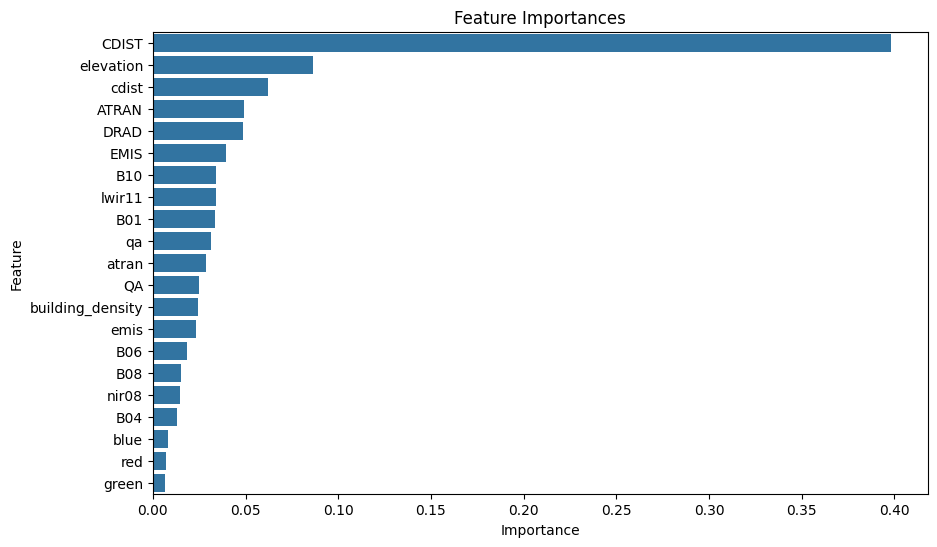

In [47]:
importances = model.feature_importances_
feature_names = uhi_data_final.drop(columns=['UHI Index']).columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('/content/Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [ ]:
# Mapping satellite data for submission.
val_data = map_satellite_data_landsat('/content/Landsat_LST.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:12<00:00, 80.71it/s]


In [ ]:
val_data_landsatog = map_satellite_data_landsatog('/content/Landsat_LST_og-2.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:18<00:00, 55.09it/s]


In [ ]:
val_data_sentinel = map_satellite_data_sentinel('/content/S2_sample-2.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:14<00:00, 73.51it/s] 


In [ ]:
val_data_elevation = map_satellite_data_elevation('/content/elevation.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 782.55it/s]


In [ ]:
val_data_building_density = map_satellite_data_building_density('/content/BuildingDensityFraction.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 788.24it/s]


In [ ]:
val_data_landcover = map_satellite_data_landcover('/content/landcover.tiff', '/content/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 762.58it/s]


In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data_sentinel['NDVI'] = (val_data_sentinel['B08'] - val_data_sentinel['B04']) / (val_data_sentinel['B08'] + val_data_sentinel['B04'])
val_data_sentinel['NDVI'] = val_data_sentinel['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

eps =  1e-8
#this is used to avoid division by zero by adding a small term to the denominator

# EVI Calculation
val_data_sentinel['EVI'] = 2.5*(val_data_sentinel['B08']-val_data_sentinel['B04'])/(val_data_sentinel['B08']+6*val_data_sentinel['B04']-7.5*val_data_sentinel['B02']+1+eps)

# SAVI Calculation
val_data_sentinel['SAVI'] = ((val_data_sentinel['B08']-val_data_sentinel['B04'])/(val_data_sentinel['B08']+val_data_sentinel['B04']+0.5+eps))*(1+0.5)

# MNDWI Calculation
val_data_sentinel['MNDWI'] = (val_data_sentinel['B03']-val_data_sentinel['B11'])/(val_data_sentinel['B03']+val_data_sentinel['B11']+eps)

# NDBI Calculation
val_data_sentinel['NDBI'] = (val_data_sentinel['B11']-val_data_sentinel['B08'])/(val_data_sentinel['B11']+val_data_sentinel['B08']+eps)

In [ ]:
val_data = combine_two_datasets(val_data,val_data_sentinel)
val_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS,B01,B02,B03,B04,B06,B08,B11,NDVI,EVI,SAVI,MNDWI,NDBI
0,48823.0,5479.0,82.0,1664.0,390.0,9557.0,811.0,459.0,617.0,432.0,2089.0,2502.0,1474.0,0.705521,3.131619,1.058102,-0.409852,-0.258551
1,48823.0,5479.0,82.0,1664.0,390.0,9557.0,1208.0,562.0,731.0,647.0,2076.0,2906.0,1751.0,0.635801,2.194056,0.953567,-0.410959,-0.248014
2,48178.0,5480.0,118.0,1663.0,369.0,9759.0,899.0,955.0,1052.0,1188.0,995.0,1246.0,1101.0,0.023829,0.119588,0.035736,-0.022759,-0.061781
3,48890.0,5479.0,75.0,1664.0,394.0,9557.0,1193.0,1132.0,1364.0,1512.0,1939.0,1774.0,2521.0,0.079732,0.277896,0.11958,-0.297812,0.173923
4,48145.0,5479.0,102.0,1664.0,379.0,9735.0,1097.0,1506.0,1642.0,1688.0,2204.0,2834.0,2248.0,0.253428,1.717626,0.3801,-0.155784,-0.115309


In [ ]:
val_data = combine_two_datasets(val_data,val_data_landsatog)
val_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS,B01,B02,B03,B04,...,NDBI,red,green,blue,nir08,lwir11,cdist,atran,qa,emis
0,48823.0,5479.0,82.0,1664.0,390.0,9557.0,811.0,459.0,617.0,432.0,...,-0.258551,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0
1,48823.0,5479.0,82.0,1664.0,390.0,9557.0,1208.0,562.0,731.0,647.0,...,-0.248014,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0
2,48178.0,5480.0,118.0,1663.0,369.0,9759.0,899.0,955.0,1052.0,1188.0,...,-0.061781,0.12117250000000002,0.11262,0.09114250000000002,0.1479025,30.573511339999982,104.0,8507.0,319.0,9758.0
3,48890.0,5479.0,75.0,1664.0,394.0,9557.0,1193.0,1132.0,1364.0,1512.0,...,0.173923,0.16635499999999998,0.14771,0.133905,0.23252,32.68584770000001,60.0,8507.0,349.0,9543.0
4,48145.0,5479.0,102.0,1664.0,379.0,9735.0,1097.0,1506.0,1642.0,1688.0,...,-0.115309,0.12510500000000002,0.12172250000000001,0.10854999999999998,0.26898500000000003,30.44020856000003,86.0,8507.0,332.0,9734.0


In [ ]:
val_data = combine_two_datasets(val_data,val_data_elevation)
val_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS,B01,B02,B03,B04,...,red,green,blue,nir08,lwir11,cdist,atran,qa,emis,elevation
0,48823.0,5479.0,82.0,1664.0,390.0,9557.0,811.0,459.0,617.0,432.0,...,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6
1,48823.0,5479.0,82.0,1664.0,390.0,9557.0,1208.0,562.0,731.0,647.0,...,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6
2,48178.0,5480.0,118.0,1663.0,369.0,9759.0,899.0,955.0,1052.0,1188.0,...,0.12117250000000002,0.11262,0.09114250000000002,0.1479025,30.573511339999982,104.0,8507.0,319.0,9758.0,50.92
3,48890.0,5479.0,75.0,1664.0,394.0,9557.0,1193.0,1132.0,1364.0,1512.0,...,0.16635499999999998,0.14771,0.133905,0.23252,32.68584770000001,60.0,8507.0,349.0,9543.0,50.92
4,48145.0,5479.0,102.0,1664.0,379.0,9735.0,1097.0,1506.0,1642.0,1688.0,...,0.12510500000000002,0.12172250000000001,0.10854999999999998,0.26898500000000003,30.44020856000003,86.0,8507.0,332.0,9734.0,7.6


In [ ]:
val_data = combine_two_datasets(val_data,val_data_building_density)
val_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS,B01,B02,B03,B04,...,green,blue,nir08,lwir11,cdist,atran,qa,emis,elevation,building_density
0,48823.0,5479.0,82.0,1664.0,390.0,9557.0,811.0,459.0,617.0,432.0,...,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6,0.0
1,48823.0,5479.0,82.0,1664.0,390.0,9557.0,1208.0,562.0,731.0,647.0,...,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6,0.0
2,48178.0,5480.0,118.0,1663.0,369.0,9759.0,899.0,955.0,1052.0,1188.0,...,0.11262,0.09114250000000002,0.1479025,30.573511339999982,104.0,8507.0,319.0,9758.0,50.92,0.0
3,48890.0,5479.0,75.0,1664.0,394.0,9557.0,1193.0,1132.0,1364.0,1512.0,...,0.14771,0.133905,0.23252,32.68584770000001,60.0,8507.0,349.0,9543.0,50.92,0.0
4,48145.0,5479.0,102.0,1664.0,379.0,9735.0,1097.0,1506.0,1642.0,1688.0,...,0.12172250000000001,0.10854999999999998,0.26898500000000003,30.44020856000003,86.0,8507.0,332.0,9734.0,7.6,0.0


In [ ]:
val_data = combine_two_datasets(val_data,val_data_landcover)
val_data.head()

,B10,CDIST,ATRAN,DRAD,QA,EMIS,B01,B02,B03,B04,...,blue,nir08,lwir11,cdist,atran,qa,emis,elevation,building_density,landcover
0,48823.0,5479.0,82.0,1664.0,390.0,9557.0,811.0,459.0,617.0,432.0,...,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6,0.0,50
1,48823.0,5479.0,82.0,1664.0,390.0,9557.0,1208.0,562.0,731.0,647.0,...,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,7.6,0.0,10
2,48178.0,5480.0,118.0,1663.0,369.0,9759.0,899.0,955.0,1052.0,1188.0,...,0.09114250000000002,0.1479025,30.573511339999982,104.0,8507.0,319.0,9758.0,50.92,0.0,50
3,48890.0,5479.0,75.0,1664.0,394.0,9557.0,1193.0,1132.0,1364.0,1512.0,...,0.133905,0.23252,32.68584770000001,60.0,8507.0,349.0,9543.0,50.92,0.0,50
4,48145.0,5479.0,102.0,1664.0,379.0,9735.0,1097.0,1506.0,1642.0,1688.0,...,0.10854999999999998,0.26898500000000003,30.44020856000003,86.0,8507.0,332.0,9734.0,7.6,0.0,10


In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['red','green','blue','nir08','lwir11','cdist','atran',
                                    'qa','emis',
                                    'B10','CDIST','ATRAN','DRAD','QA','EMIS','B01',
                                    'B04','B06','B08','elevation','building_density', 'landcover']]
submission_val_data.head()

,red,green,blue,nir08,lwir11,cdist,atran,qa,emis,B10,...,DRAD,QA,EMIS,B01,B04,B06,B08,elevation,building_density,landcover
0,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,48823.0,...,1664.0,390.0,9557.0,811.0,432.0,2089.0,2502.0,7.6,0.0,50
1,0.051844999999999974,0.06488,0.02907499999999999,0.24341000000000002,32.06035004,66.0,8507.0,346.0,9543.0,48823.0,...,1664.0,390.0,9557.0,1208.0,647.0,2076.0,2906.0,7.6,0.0,10
2,0.12117250000000002,0.11262,0.09114250000000002,0.1479025,30.573511339999982,104.0,8507.0,319.0,9758.0,48178.0,...,1663.0,369.0,9759.0,899.0,1188.0,995.0,1246.0,50.92,0.0,50
3,0.16635499999999998,0.14771,0.133905,0.23252,32.68584770000001,60.0,8507.0,349.0,9543.0,48890.0,...,1664.0,394.0,9557.0,1193.0,1512.0,1939.0,1774.0,50.92,0.0,50
4,0.12510500000000002,0.12172250000000001,0.10854999999999998,0.26898500000000003,30.44020856000003,86.0,8507.0,332.0,9734.0,48145.0,...,1664.0,379.0,9735.0,1097.0,1688.0,2204.0,2834.0,7.6,0.0,10


In [ ]:
# Feature Scaling
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [ ]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963129
1,-73.971928,40.788875,0.962861
2,-73.967080,40.789080,0.964321
3,-73.972550,40.789082,0.962169
4,-73.969697,40.787953,0.959062


In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.
We obtained a score of 0.96 on the EY platform

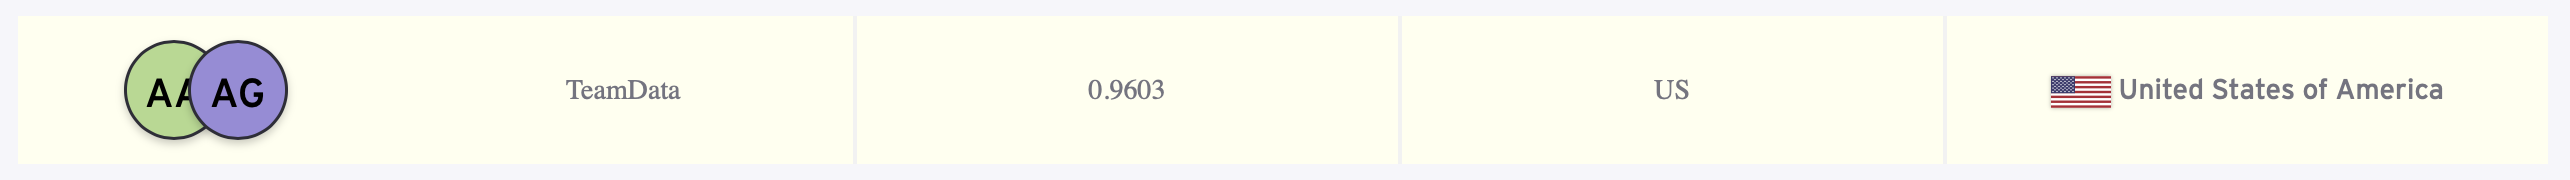